In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.activity_common import get_tfa, get_decay_per_cell, get_alpha_per_cell, calc_activity_expression, calculate_alpha
from jtb_2022_code import FigureSingleCellData
from jtb_2022_code.figure_constants import INFERELATOR_RESULTS_FILE, INFERELATOR_PRIORS_FILE

import numpy as np
import pandas as pd
import gc

FIG6_TFS = ["YNL216W", "YER040W"]

/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-03-10 16:28:16 2 Preprocessing methods selected: Predictor method zscore [limit 10] Response method zscore [limit 10] Pre-TFA expression method robustscaler [limit 20] 


In [3]:
data = FigureSingleCellData()
#for k in data.expts:
#    data.decay_data(*k, recalculate=True)

#data.decay_data_all(recalculate=True)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
_rapa_decays = data.all_data.varm['rapamycin_window_decay'].copy()
_var = data.all_data.var.copy()
data._unload()

In [5]:
import anndata as ad
from jtb_2022_code.figure_constants import INFERELATOR_DATA_FILE

adata = ad.read(INFERELATOR_DATA_FILE)
adata

AnnData object with n_obs × n_vars = 162529 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'program_0_time', 'program_1_time', 'program_rapa_time_denoised', 'program_cc_time_denoised', 'UMAP_1', 'UMAP_2', 'PCA_1', 'PCA_2'
    var: 'CommonName', 'category', 'programs', 'leiden'
    uns: 'programs'
    layers: 'decay_constants', 'denoised', 'velocity'

In [ ]:
adata

In [ ]:
dd

In [ ]:
dd.layers['transcription'] = np.full(dd.X.shape, np.nan)

for i, n in [('0', 'rapamycin'), ('1', 'cell_cycle')]:
    
    _pidx = data.all_data.var['programs'] == i
    dd.layers['transcription'][:, _pidx] = calculate_alpha(
        dd,
        velocity_layer=f"{n}_velocity",
        decay_layer='decay_constants'
    )[:, _pidx]
    
np.maximum(dd.layers['transcription'], 0, out=dd.layers['transcription'])

In [ ]:
from inferelator.tfa.pinv_tfa import (
    ActivityOnlyPinvTFA
)
from inferelator.utils import InferelatorData, inferelator_verbose_level

def get_tfa(adata, layer='X', out_obsm='tfa', out_uns='tfa', recalculate=False):
    
    if out_uns in adata.uns and not recalculate:
        return adata
    
    prior = pd.read_csv(INFERELATOR_PRIORS_FILE, sep="\t", index_col=0)
    prior = prior.reindex(adata.var_names, axis=0).fillna(0).astype(int)
    prior = prior.loc[:, (prior != 0).sum(axis=0) > 0].copy()
        
    lref = adata.X if layer == 'X' else adata.layers[layer]
        
    adata.obsm[out_obsm] = ActivityOnlyPinvTFA().compute_transcription_factor_activity(
            prior,
            InferelatorData(
                expression_data=lref,
                gene_names=adata.var_names,
                sample_names=adata.obs_names
            ),
            keep_self=True
        ).values
    
    adata.uns[out_uns] = {
        'columns': prior.columns,
        'layer': layer,
        'obms_key': out_obsm
    }
    
    return adata

get_tfa(adata, layer='transcription')
get_tfa(adata, layer='X', out_obsm='X_tfa', out_uns='X_tfa')

In [ ]:
dd.uns['tfa']['columns'][np.var(dd.obsm['tfa'], axis=0).argmax()]

In [ ]:
from jtb_2022_code.utils.figure_common import *
from inferelator_velocity.utils.aggregation import aggregate_sliding_window_times

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(5, 3), dpi=300)

tf = "YPL075W"
for i, k in enumerate(['tfa', 'X_tfa']):
    ax[i].scatter(
        dd.obs['program_0_time'],
        dd.obsm[k][:, dd.uns[k]['columns'] == tf],
        s=1,
        c=to_pool_colors(dd.obs['Pool']),
        alpha=0.25
    )
    ax[i].set_xlim(-10, 65)
    ax[i].set_ylim(-1.5, 1.5)
    
    if i == 0:
        ax[i].set_title(f"{data.gene_common_name(tf)} Activity\n(Transcription)")
    else:
        ax[i].set_title(f"{data.gene_common_name(tf)} Activity\n(Expression)")
    ax[i].set_xlabel(f"Time [min]")
    
    if i == 0:
        ax[i].set_ylabel(f"Activity")

    window_y, window_x = aggregate_sliding_window_times(
        dd.obsm[k][:, dd.uns[k]['columns'] == tf].reshape(-1, 1),
        dd.obs['program_0_time'].values,
        agg_func=np.median,
        centers=np.arange(-9, 60),
        width=2.0
    )

    ax[i].plot(
        window_x,
        window_y,
        color='black'
    )
    
fig.tight_layout()

fig.savefig("GCR1_activity.png", facecolor='white')

In [ ]:
(dd.uns['tfa']['columns'] == "YDR223W").sum()

In [ ]:
aggregate_sliding_window_times(
        dd.obsm['tfa'][:, dd.uns['tfa']['columns'] == tf].reshape(-1, 1),
        dd.obs['program_0_time'].values,
        agg_func=np.median,
        centers=np.arange(-9, 60),
        width=2.0
    )

<ipython-input-6-986ec9a19e05>:43: RuntimeWarning: divide by zero encountered in divide
  y=np.log(2) / adata.layers['decay_constants'][:, _tf_idx][overplot_shuffle],


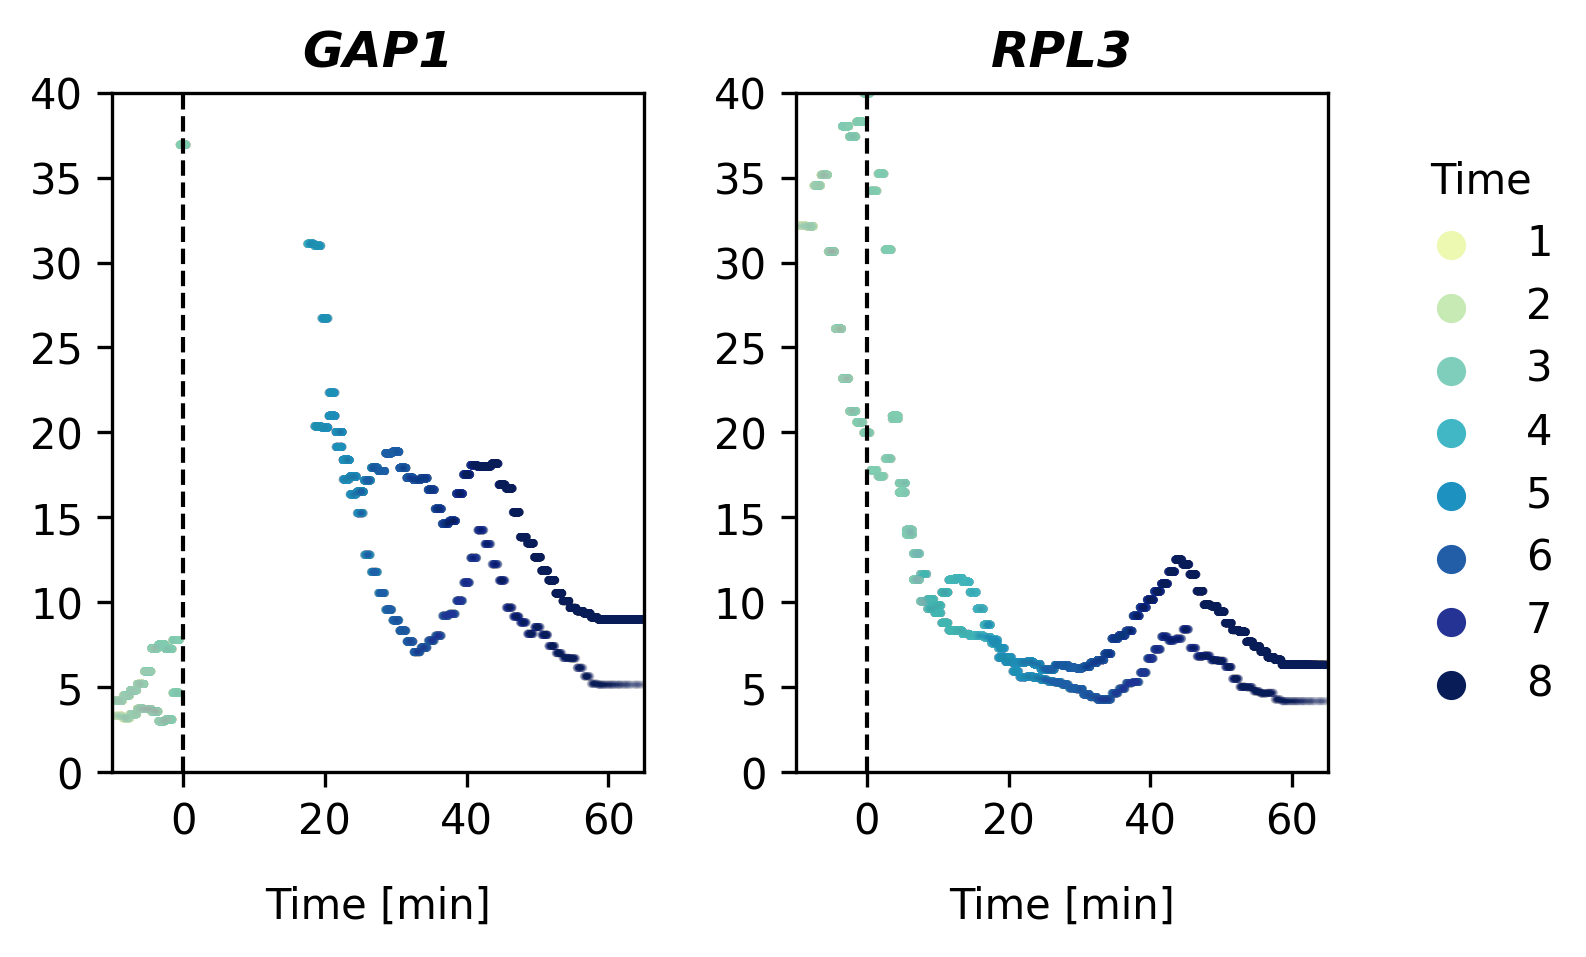

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from jtb_2022_code.utils.figure_common import *

rgen = np.random.default_rng(239876)

layout = [['decay_0', '.', 'decay_1', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 3), dpi=300)

time_data = adata.obs['program_0_time'].values
color_data = adata.obs['Pool'].map(
    {k: v for k, v in zip(range(1, 9), pool_palette())}
).values

for i, tf in enumerate(FIGURE_4_GENES):

    _tf_idx = adata.var_names == tf
    _key = f"decay_{i}"
    
    axd[_key].set_title(
        data.gene_common_name(tf),
        fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
    )
        
    axd[_key].set_xlabel("Time [min]", labelpad=10)

    overplot_shuffle = np.arange(color_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    fig_refs[_key] = axd[_key].scatter(
        x=time_data[overplot_shuffle], 
        y=np.log(2) / adata.layers['decay_constants'][:, _tf_idx][overplot_shuffle],
        color=color_data[overplot_shuffle],
        s=1,
        alpha=0.01
    )
        
    axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
    
    _ylims = axd[_key].get_ylim()
    _ylims = axd[_key].set_ylim(0, min(_ylims[1], 40))
    axd[_key].set_xlim(-10, 65)

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    adata.obs['Pool'].dtype.categories.values,
    title="Time"
)

In [7]:
from inferelator.preprocessing.velocity import (
    extract_transcriptional_output
)
from inferelator.utils import InferelatorData
import scanpy as sc

layer_ref = adata.layers['denoised']
#layer_ref = adata.X

adata.layers['transcriptional_output'] = extract_transcriptional_output(
    InferelatorData(
        expression_data=layer_ref,
        gene_names=adata.var_names,
        sample_names=adata.obs_names
    ),
    InferelatorData(
        expression_data=adata.layers['velocity'],
        gene_names=adata.var_names,
        sample_names=adata.obs_names
    ),
    gene_and_sample_decay=adata.layers['decay_constants'],
    decay_constant_maximum=np.log(2)
).values

try:
    adata.layers['decay_component'] = layer_ref.multiply(adata.layers['decay_constants'])
except AttributeError:
    adata.layers['decay_component'] = np.multiply(layer_ref, adata.layers['decay_constants'])
    
try:
    adata.layers['decay_component'] = adata.layers['decay_component'].tocsr()
except AttributeError:
    pass

adata

2023-03-10 16:33:08 2 Modeling transcription with velocity and decay per sample and per gene


AnnData object with n_obs × n_vars = 162529 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'program_0_time', 'program_1_time', 'program_rapa_time_denoised', 'program_cc_time_denoised', 'UMAP_1', 'UMAP_2', 'PCA_1', 'PCA_2'
    var: 'CommonName', 'category', 'programs', 'leiden'
    uns: 'programs'
    layers: 'decay_constants', 'denoised', 'velocity', 'transcriptional_output', 'decay_component'

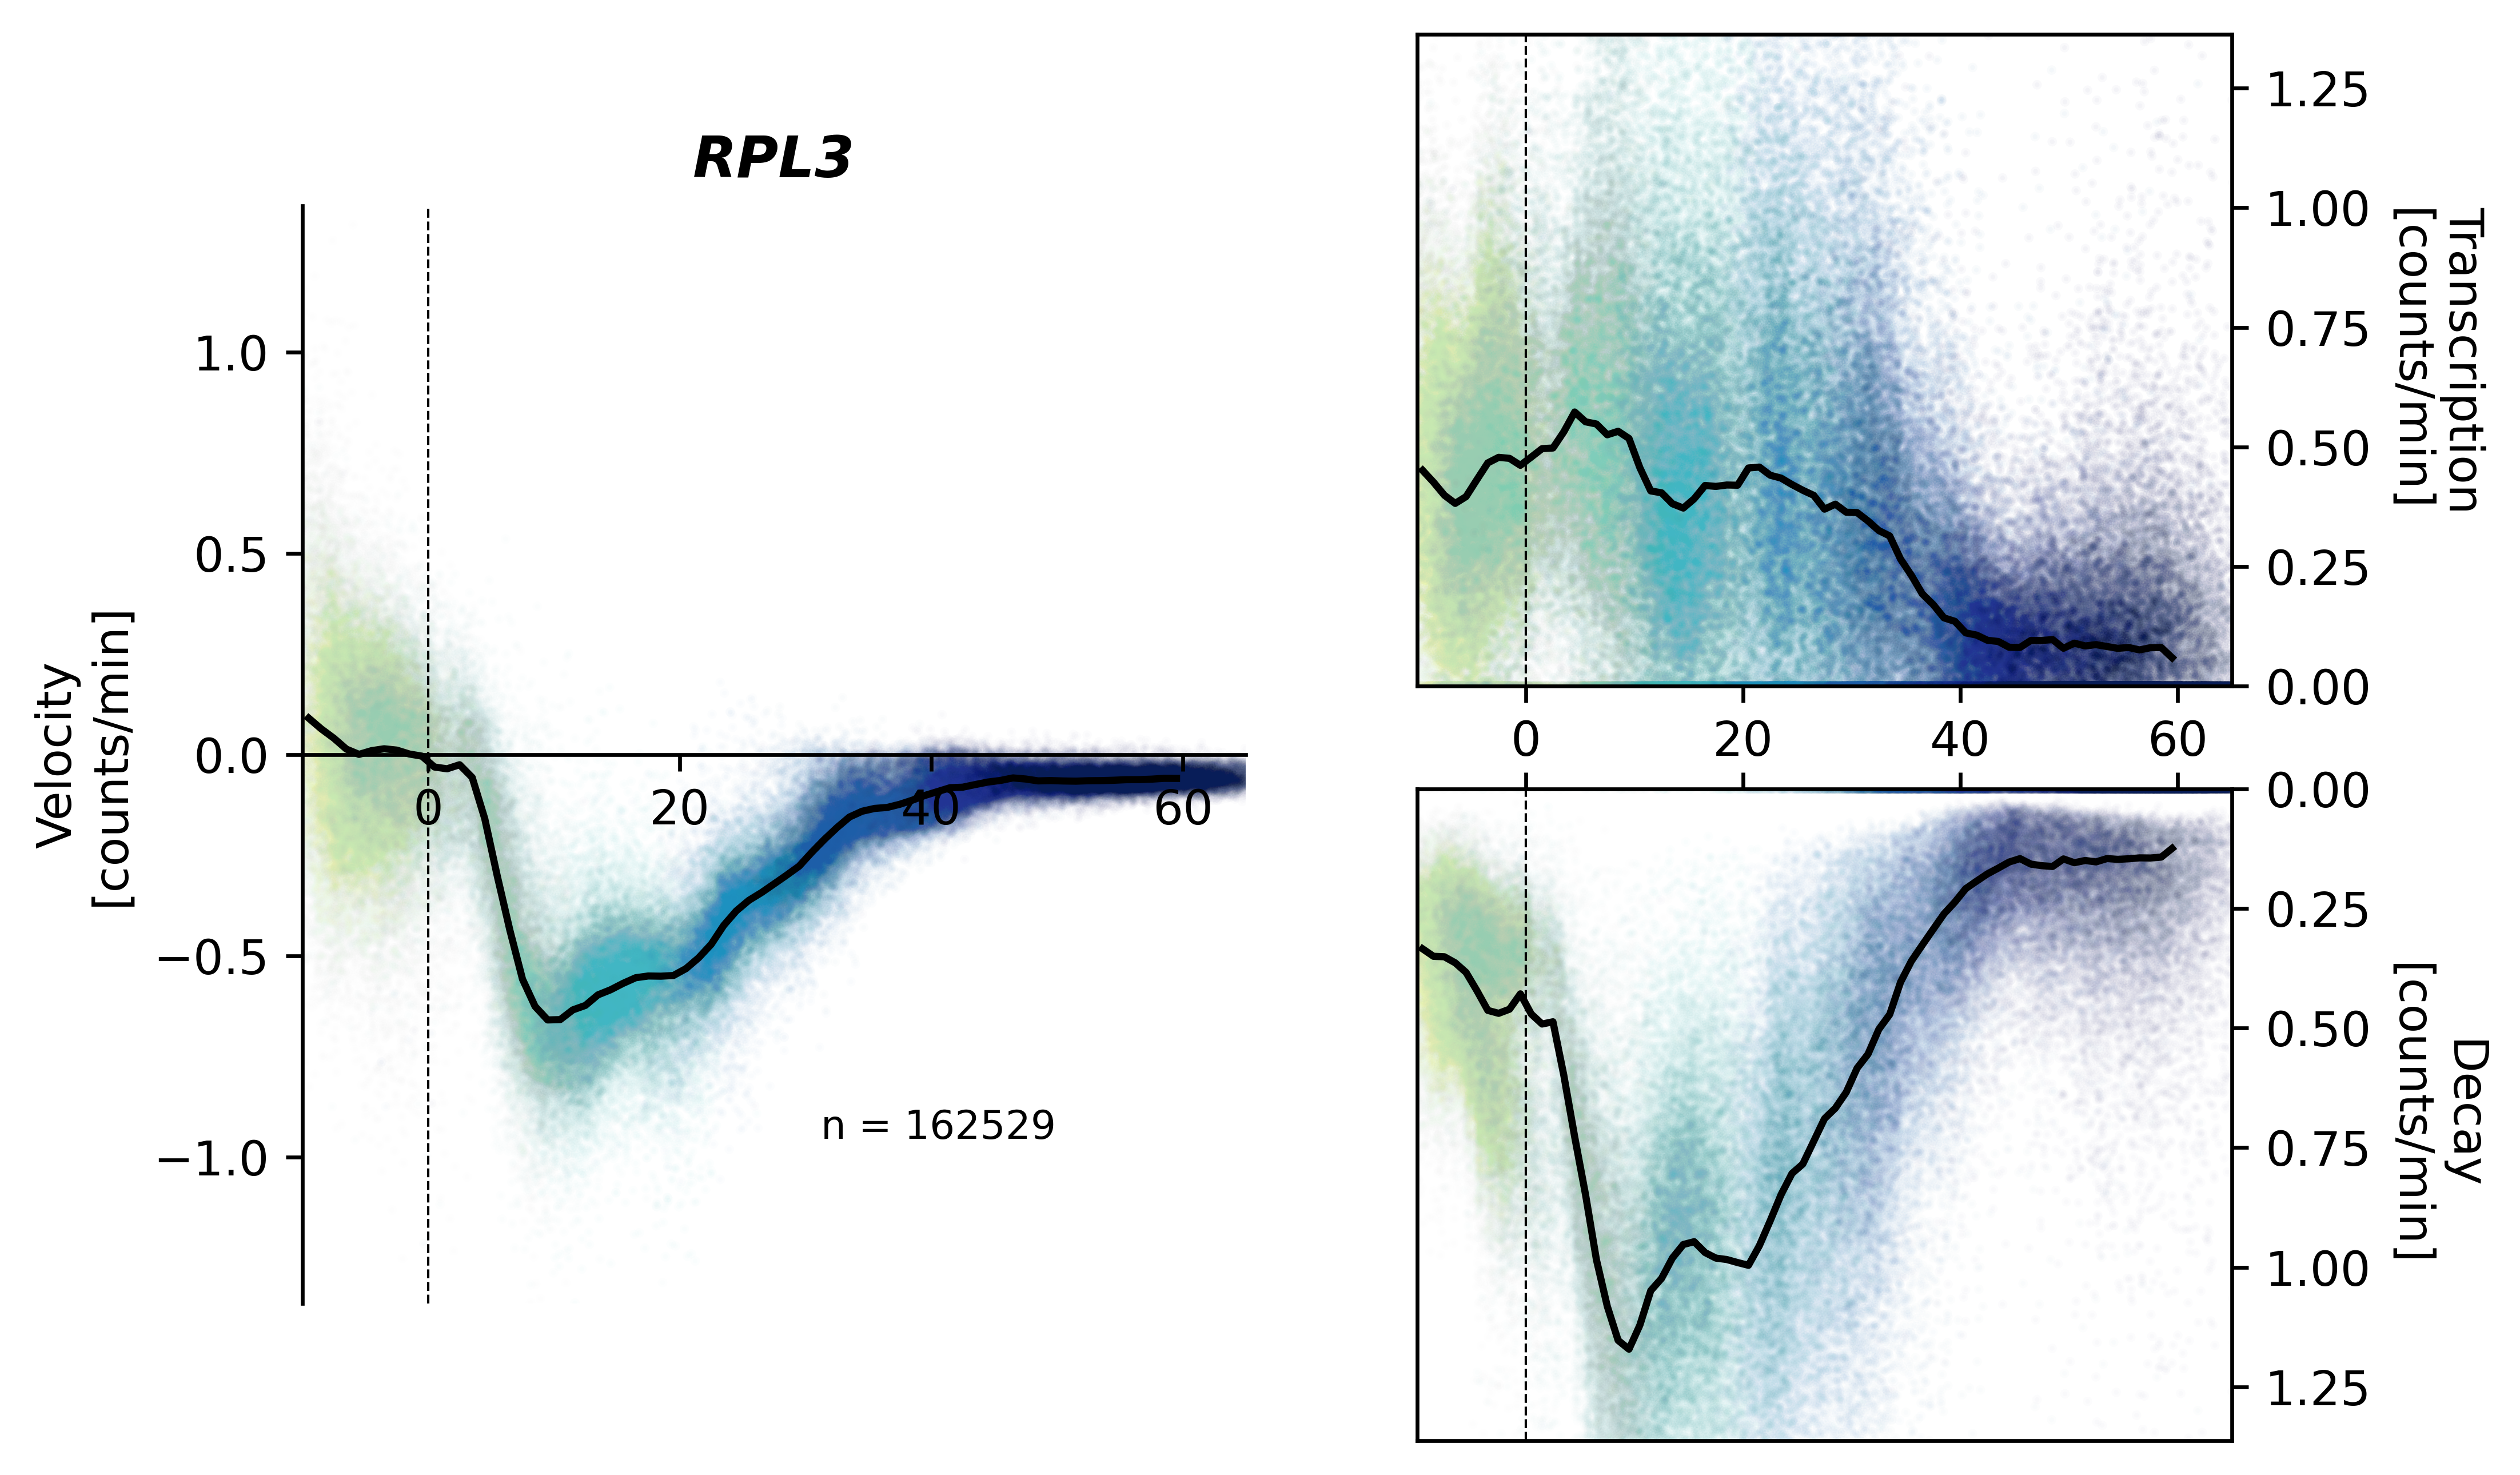

In [10]:
from inferelator_velocity.utils.aggregation import aggregate_sliding_window_times

gene = FIGURE_4_GENES[1]
#gene = 'YLR110C'
#gene = "YDR224C"
time_data = adata.obs['program_0_time'].values
#time_data = adata.obs['program_1_time'].values
color_data = to_pool_colors(adata.obs['Pool'])
#color_data = to_cc_colors(adata.obs['CC'])

overplot_shuffle = np.arange(color_data.shape[0])
rgen.shuffle(overplot_shuffle)

_idx = adata.var_names == gene

try:
    _gene_data = np.vstack((
        adata.layers['velocity'][:, _idx].ravel(),
        np.maximum(adata.layers['transcriptional_output'][:, _idx].ravel(), 0),
        adata.layers['decay_component'][:, _idx].ravel()
    ))
except AttributeError:
    _gene_data = np.vstack((
        adata.layers['velocity'][:, _idx].ravel(),
        np.maximum(adata.layers['transcriptional_output'][:, _idx].ravel(), 0),
        adata.layers['decay_component'][:, _idx].A.ravel()
    ))

_agg_x = np.arange(-10, 60) + 0.5
_agg_data = np.vstack(list(
    aggregate_sliding_window_times(
        _gene_data[i, :].reshape(-1, 1),
        adata.obs['program_0_time'].values,
        #adata.obs['program_1_time'].values,
        agg_func=np.median,
        centers=_agg_x,
        width=1.0
    )[0] for i in range(3)
))

# Trim off outliers to improve plot
_abs_bound = np.abs(np.nanquantile(_gene_data, [0.02, 0.98], axis=None)).max()
_abs_bound

fig = plt.figure(figsize=(5, 4), dpi=600)

axd = {
    'velocity': fig.add_axes([0, 0.1, 0.55, 0.8]),
    'transcription': fig.add_axes([0.65, 0.55, 0.475, 0.475]),
    'decay': fig.add_axes([0.65, 0, 0.475, 0.475]),
}

for k, ax in axd.items():
    ax.set_xlim(-10, 65)
    ax.axvline(
        0, 0, 1,
        linestyle='--',
        linewidth=0.5,
        c='black'
    )
    
    if k == 'velocity':
        ax.spines['left'].set_position(('axes', 0.0))
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0.0))
        ax.spines['top'].set_color('none')
        ax.set_title(
            data.gene_common_name(gene),
            fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
        )
        ax.set_ylim(-1 * _abs_bound, _abs_bound)
    else:
        ax.set_ylim(0, _abs_bound)

axd['decay'].invert_yaxis()
axd['decay'].yaxis.tick_right()
axd['decay'].xaxis.tick_top()
axd['decay'].xaxis.set_ticklabels([])
axd['decay'].yaxis.set_label_position("right")
axd['decay'].set_ylabel("Decay\n[counts/min]", rotation=270, labelpad=24)

axd['transcription'].yaxis.tick_right()
axd['transcription'].yaxis.set_label_position("right")
axd['transcription'].set_ylabel("Transcription\n[counts/min]", rotation=270, labelpad=24)

axd['velocity'].set_ylabel("Velocity\n[counts/min]")
        
axd['velocity'].scatter(
    x=time_data[overplot_shuffle], 
    y=_gene_data[0, :][overplot_shuffle],
    color=color_data[overplot_shuffle],
    s=1,
    alpha=0.01
)

axd['velocity'].plot(
    _agg_x, 
    _agg_data[0, :],
    color='black'
)

axd['velocity'].annotate(
    f"n = {len(color_data)}",
    xy=(0.55, 0.15),  
    xycoords='axes fraction',
    xytext=(0.55, 0.15), 
    textcoords='axes fraction',
    fontsize='small'
)

axd['transcription'].scatter(
    x=time_data[overplot_shuffle], 
    y=_gene_data[1, :][overplot_shuffle],
    color=color_data[overplot_shuffle],
    s=1,
    alpha=0.01
)

axd['transcription'].plot(
    _agg_x, 
    _agg_data[1, :],
    color='black'
)

axd['transcription'].scatter(
    x=time_data[overplot_shuffle], 
    y=_gene_data[1, :][overplot_shuffle],
    color=color_data[overplot_shuffle],
    s=1,
    alpha=0.01
)

axd['decay'].scatter(
    x=time_data[overplot_shuffle], 
    y=_gene_data[2, :][overplot_shuffle],
    color=color_data[overplot_shuffle],
    s=1,
    alpha=0.01
)

axd['decay'].plot(
    _agg_x, 
    _agg_data[2, :],
    color='black'
)

fig.savefig("Figure_6" + ".png", facecolor="white", bbox_inches='tight', dpi=600) 

<ipython-input-11-66bec37a00dc>:51: RuntimeWarning: divide by zero encountered in divide
  _gene_vals = np.log(2) / _gene_vals


dc_0 NNZ: (136350 / 162529)
velo_0 NNZ: (94079 / 162529)
act_0 NNZ: (140209 / 162529)
dec_0 NNZ: (78018 / 162529)
dc_1 NNZ: (162529 / 162529)
velo_1 NNZ: (30704 / 162529)
act_1 NNZ: (142599 / 162529)
dec_1 NNZ: (151665 / 162529)


AttributeError: 'NoneType' object has no attribute 'obs'

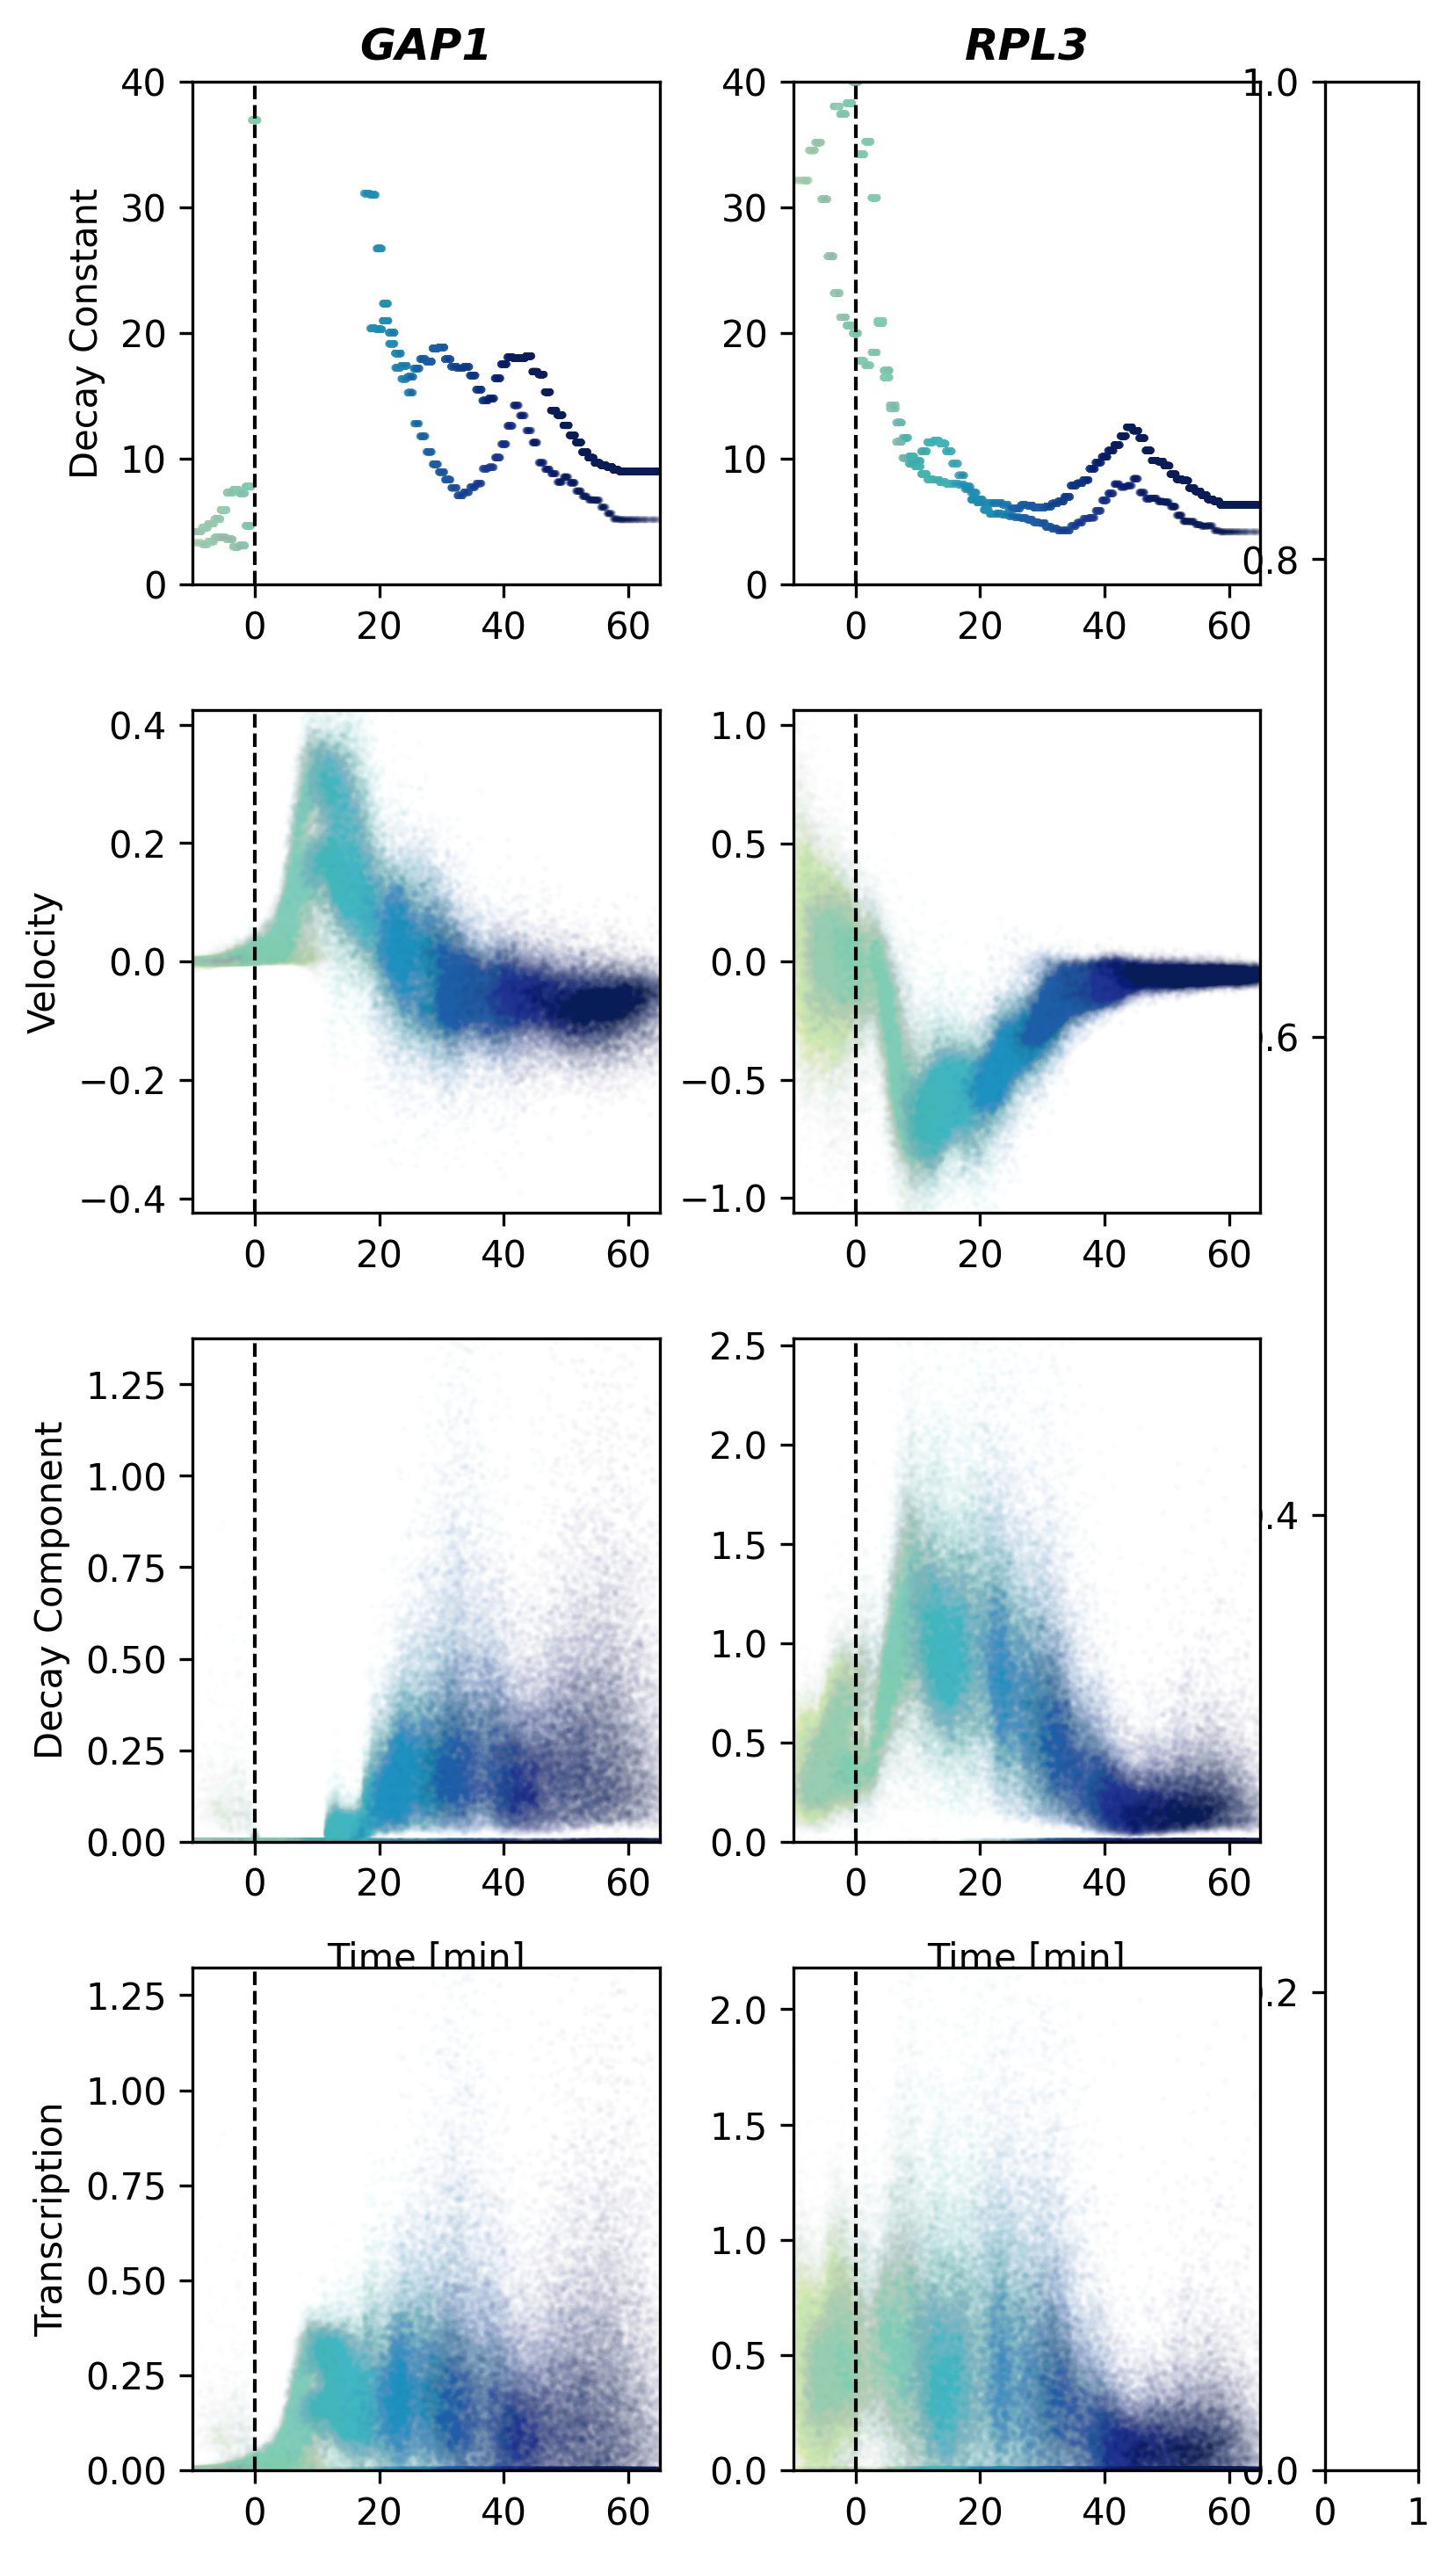

In [11]:
import scipy.sparse as sps

rgen = np.random.default_rng(239876)

layout = [
    ['dc_0', '.', 'dc_1', 'time_lgd'],
    ['velo_0', '.', 'velo_1', 'time_lgd'],
    ['dec_0', '.', 'dec_1', 'time_lgd'],
    ['act_0', '.', 'act_1', 'time_lgd']
]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1, 1, 1, 1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 12), dpi=300)

time_data = adata.obs['program_0_time'].values
color_data = to_pool_colors(adata.obs['Pool'])

#color_data = adata.obs['Experiment'].map(
#    {k: v for k, v in zip(range(1, 3), expt_palette())}
#).values

for i, gene in enumerate(FIGURE_4_GENES):
    
    for j, (key, ylab, layer) in enumerate([
        ['dc', 'Decay Constant', 'decay_constants'],
        ['velo', 'Velocity', 'velocity'],
        ['act', 'Transcription', 'transcriptional_output'],
        ['dec', 'Decay Component', 'decay_component']
    ]):

        _tf_idx = adata.var_names == gene

        if layer == 'transcriptional_output':
            lref = np.maximum(adata.layers[layer], 0)
        else:
            lref = adata.layers[layer]
            
        _gene_vals = lref[:, _tf_idx]
    
        try:
            _gene_vals = _gene_vals.A.ravel()
        except AttributeError:
            _gene_vals = _gene_vals.ravel()
            
        if layer == 'decay_constants':
            _gene_vals = np.log(2) / _gene_vals            
           
        _key = f"{key}_{i}"
        
        print(f"{_key} NNZ: ({np.sum(_gene_vals > 0)} / {len(_gene_vals)})")

        if i == 0:
            axd[_key].set_ylabel(ylab)

        if j == 0:
            axd[_key].set_title(
                data.gene_common_name(gene),
                fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
            )
            axd[_key].set_ylim(0, 40)
        elif j == 1:
            _abs_bound = np.abs(np.nanquantile(_gene_vals, [0.001, 0.999])).max()
            axd[_key].set_ylim(_abs_bound * -1, _abs_bound)
        else:
            _abs_bound = np.nanquantile(_gene_vals, 0.999)
            axd[_key].set_ylim(0, _abs_bound)            
        
        if j == 3:
            axd[_key].set_xlabel("Time [min]", labelpad=10)

        overplot_shuffle = np.arange(color_data.shape[0])
        rgen.shuffle(overplot_shuffle)

        fig_refs[_key] = axd[_key].scatter(
            x=time_data[overplot_shuffle], 
            y=_gene_vals[overplot_shuffle],
            color=color_data[overplot_shuffle],
            s=1,
            alpha=0.01
        )

        axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
        axd[_key].set_xlim(-10, 65)

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    data.all_data.obs['Pool'].dtype.categories.values,
    title="Time"
)


In [ ]:
prior = pd.read_csv(INFERELATOR_PRIORS_FILE, sep="\t", index_col=0)
prior = prior.reindex(adata.var_names, axis=0).fillna(0).astype(int)
prior = prior.loc[:, (prior != 0).sum(axis=0) > 0].copy()

activity_data = ad.AnnData(
    calc_activity_expression(
        adata,
        prior,
        layer='X',
        velocity_layer='velocity',
        decay_constants=adata.layers['decay_constants']
    ),
    obs=adata.obs
)
activity_data.var_names=prior.columns
activity_data.layers['expression'] = calc_activity_expression(
    adata,
    prior,
    layer='X'
)


In [ ]:
activity_data.uns['window_rapa_activity'] = aggregate_sliding_window_times(
    activity_data.X,
    adata.obs['program_0_time'].values,
    agg_func=np.median,
    agg_kwargs={'axis': 0},
    centers=np.arange(-9, 60),
    width=2.0
)[0]

activity_data.uns['window_rapa_activity_expr_only'] = aggregate_sliding_window_times(
    activity_data.layers['expression'],
    adata.obs['program_0_time'].values,
    agg_func=np.median,
    agg_kwargs={'axis': 0},
    centers=np.arange(-9, 60),
    width=2.0
)[0]

activity_data.uns['window_counts_rapa'] = aggregate_sliding_window_times(
    adata.X,
    adata.obs['program_0_time'].values,
    agg_func=lambda x: x.mean(axis=0).A1,
    centers=np.arange(-9, 60),
    width=2.0
)[0]

In [ ]:
agg_adata = ad.AnnData(
    _rapa_decays.T[9:, :],
    dtype=float
)
agg_adata.var_names = adata.var_names
agg_adata.var = _var
agg_adata.layers['counts'] = activity_data.uns['window_counts_rapa'][9:, :].copy()
agg_adata.varm['initial_state'] = activity_data.uns['window_counts_rapa'][0:9, :].mean(axis=0)
agg_adata.uns['rapa_activity'] = activity_data.uns['window_rapa_activity'][9:, :].copy()
agg_adata.uns['rapa_activity_expr_only'] = activity_data.uns['window_rapa_activity_expr_only'][9:, :].copy()
agg_adata.uns['rapa_activity_tf_names'] = activity_data.var_names.tolist()
agg_adata.obs['time'] = np.arange(60)
agg_adata.write("2021_INFERELATOR_AGGREGATES.h5ad")
agg_adata

In [ ]:
predict_adata = ad.read("/scratch/cj59/RAPA/2021_PREDICTS.h5ad")

rgen = np.random.default_rng(239876)

layout = [['decay_0', '.', 'decay_1', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(5, 2), dpi=300)

time_data = adata.obs['program_0_time'].values
color_data = adata.obs['Pool'].map(
    {k: v for k, v in zip(range(1, 9), pool_palette())}
).values

#for i, tf in enumerate(FIGURE_4_GENES):
for i, tf in enumerate(["YGR192C", "YLR110C"]):

    _tf_idx = adata.var_names == tf
    _key = f"decay_{i}"
    
    axd[_key].set_title(
        data.gene_common_name(tf),
        fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
    )
        
    axd[_key].set_xlabel("Time [min]", labelpad=10)

    overplot_shuffle = np.arange(color_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    fig_refs[_key] = axd[_key].scatter(
        x=time_data[overplot_shuffle], 
        y=adata.layers['denoised'][:, _tf_idx][overplot_shuffle],
        color=color_data[overplot_shuffle],
        s=1,
        alpha=0.01
    )
    
    if i == 0:
        axd[_key].set_ylabel("Expression [counts]", labelpad=10)
    
    axd[_key].plot(
        predict_adata.obs['time'],
        predict_adata.X[:, predict_adata.var_names.get_loc(tf)],
        color='black',
        alpha=1
    )
        
    axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
    
    _ylims = axd[_key].get_ylim()
    _ylims = axd[_key].set_ylim(0, min(_ylims[1], 150))
    axd[_key].set_xlim(-10, 65)

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    adata.obs['Pool'].dtype.categories.values,
    title="Time"
)

In [ ]:
predict_adata

In [ ]:
rgen = np.random.default_rng(239876)

layout = [['act_0', '.', 'act_1', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 3), dpi=300)

time_data = activity_data.obs['program_0_time'].values
color_data = activity_data.obs['Pool'].map(
    {k: v for k, v in zip(range(1, 9), pool_palette())}
).values

for i, tf in enumerate(FIG6_TFS):

    _tf_idx = activity_data.var_names == tf
    
    lref = activity_data.X
    _key = f"act_{i}"
        
    if i == 0:
        axd[_key].set_ylabel("Activity")


    axd[_key].set_title(
        data.gene_common_name(tf),
        fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
    )

    axd[_key].set_xlabel("Time [min]", labelpad=10)

    overplot_shuffle = np.arange(color_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    fig_refs[_key] = axd[_key].scatter(
        x=time_data[overplot_shuffle], 
        y=lref[:, _tf_idx][overplot_shuffle],
        color=color_data[overplot_shuffle],
        s=1,
        alpha=0.01
    )

    axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    data.all_data.obs['Pool'].dtype.categories.values,
    title="Time"
)


In [ ]:
from inferelator_velocity.utils.aggregation import aggregate_sliding_window_times
import numpy as np

_wt_idx = activity_data.obs['Gene'] == "WT"

k = activity_data.shape[1]
window_activity = np.full((75, k), np.nan, dtype=float)

for i in range(k):
    window_activity[:, i], _window_centers = aggregate_sliding_window_times(
        activity_data.layers['rapamycin_transcription_out'][_wt_idx, i].reshape(-1, 1),
        activity_data.obs['program_0_time'].values[_wt_idx],
        centers=np.linspace(-10 + 0.5, 65 - 0.5, 75),
        width=1.
    )

window_activity = window_activity - window_activity[0:11, :].mean(axis=0)[None, :]

In [ ]:
_alpha_channel = np.full(k, 0.1, dtype=float)
_alpha_channel[(window_activity.max(axis=0) - window_activity.min(axis=0)) > 0.05] = 0.5
_alpha_channel[window_activity.max(axis=0).argmax()] = 1.
_alpha_channel[window_activity.min(axis=0).argmin()] = 1.

_color_channel = np.full(k, 'black', dtype=object)
_color_channel[window_activity.max(axis=0).argmax()] = 'red'
_color_channel[window_activity.min(axis=0).argmin()] = 'blue'

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from jtb_2022_code.utils.decay_common import _halflife
from scipy.stats import zscore

fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)

_ylim = np.abs(window_activity).max()

ax.set_title("TF Activity")
ax.set_xlabel("Time [min]")
ax.set_ylabel("$ \Delta $ Activity")
ax.set_ylim(-1 * _ylim, _ylim)
ax.axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')

for i in range(k):
    ax.plot(
        _window_centers, 
        window_activity[:, i], 
        marker=".", 
        linestyle='-', 
        linewidth=1.0, 
        markersize=1, 
        c=_color_channel[i],
        alpha=_alpha_channel[i]
    )

ax.annotate(
    data.gene_common_name(activity_data.var_names[window_activity.min(axis=0).argmin()]),
    (0.50, 0.1),
    xycoords='axes fraction',
    fontsize='medium',
    color='blue'
)

ax.annotate(
    data.gene_common_name(activity_data.var_names[window_activity.max(axis=0).argmax()]),
    (0.65, 0.8),
    xycoords='axes fraction',
    fontsize='medium',
    color='red'
)

fig.savefig("TF_activity_line.png", facecolor='white', bbox_inches='tight')

In [ ]:
get_alpha_per_cell(data).write("/scratch/cj59/RAPA/2021_RAPA_INFERELATOR_ALPHA.h5ad")

In [ ]:
inferelator_results = pd.read_csv(INFERELATOR_RESULTS_FILE, sep="\t")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from jtb_2022_code.utils.figure_common import *

rgen = np.random.default_rng(239876)

layout = [['decay_0', '.', 'decay_1', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 3), dpi=300)

_wt_idx = data.all_data.obs['Gene'] == "WT"
_wt_idx = _wt_idx.values

time_data = data.all_data.obs.loc[_wt_idx, 'program_0_time'].values
color_data = data.all_data.obs.loc[_wt_idx, 'Pool'].map(
    {k: v for k, v in zip(range(1, 9), pool_palette())}
).values

for i, tf in enumerate(FIGURE_4_GENES):

    _tf_idx = data.all_data.var_names == tf
    _key = f"decay_{i}"
    
    axd[_key].set_title(
        data.gene_common_name(tf),
        fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
    )
        
    axd[_key].set_xlabel("Time [min]", labelpad=10)

    overplot_shuffle = np.arange(color_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    fig_refs[_key] = axd[_key].scatter(
        x=time_data[overplot_shuffle], 
        y=np.log(2) / data.all_data.layers['decay_constants'][:, _tf_idx][_wt_idx][overplot_shuffle],
        color=color_data[overplot_shuffle],
        s=1,
        alpha=0.01
    )
        
    axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
    
    _ylims = axd[_key].get_ylim()
    _ylims = axd[_key].set_ylim(0, min(_ylims[1], 40))
    axd[_key].set_xlim(-10, 65)

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    data.all_data.obs['Pool'].dtype.categories.values,
    title="Time"
)


In [ ]:
for col in ['program_rapa_time', 'program_cc_time']:
    
    activity_data.obs[col] = ""
    
    for e, g in data.expts:
        _idx = activity_data.obs['Gene'] == g
        _idx &= activity_data.obs['Experiment'] == e
        
        activity_data.obs.loc[_idx, col] = data.expt_data[e, g].obs[col]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from scipy.stats import zscore

from jtb_2022_code.utils.figure_common import *

rgen = np.random.default_rng(239876)

layout = [['activity_0_0', '.', 'activity_0_1', 'time_lgd'],
          ['activity_1_0', '.', 'activity_1_1', 'time_lgd'],
          ['activity_2_0', '.', 'activity_2_1', 'time_lgd'],
          ['inferelator', 'inferelator', 'inferelator', '.']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1, 1, 1, 1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 8), dpi=300)

_wt_idx = activity_data.obs['Gene'] == "WT"
_wt_idx = _wt_idx.values

time_data = activity_data.obs.loc[_wt_idx, 'program_rapa_time'].values
color_data = activity_data.obs.loc[_wt_idx, 'Pool'].map(
    {k: v for k, v in zip(range(1, 9), pool_palette())}
).values

for i, tf in enumerate(FIG6_TFS):

    _tf_idx = activity_data.var_names == tf
    
    for j, origin in enumerate(["X", "rapamycin_velocity", "rapamycin_transcription_out"]):
        lref = activity_data.X if origin == "X" else activity_data.layers[origin]
        _key = f"activity_{j}_{i}"
        
        if i == 0:
            if j == 0:
                axd[_key].set_ylabel("Activity\n[Expression]")
            elif j == 1:
                axd[_key].set_ylabel("Activity\n[Velocity]")
            elif j == 2:
                axd[_key].set_ylabel("Activity\n[Transcription]")

        if j == 0:
            axd[_key].set_title(
                data.gene_common_name(tf),
                fontdict={'fontweight': 'bold', 'fontstyle': 'italic'}
            )
        
        if j == 2:
            axd[_key].set_xlabel("Time [min]", labelpad=10)

        overplot_shuffle = np.arange(color_data.shape[0])
        rgen.shuffle(overplot_shuffle)

        fig_refs[_key] = axd[_key].scatter(
            x=time_data[overplot_shuffle], 
            y=zscore(lref[:, _tf_idx][_wt_idx][overplot_shuffle]),
            color=color_data[overplot_shuffle],
            s=1,
            alpha=0.01
        )
        
        axd[_key].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')

    
fig_refs['time_lgd'] = add_legend(
    axd['time_lgd'],
    pool_palette(), 
    data.all_data.obs['Pool'].dtype.categories.values,
    title="Time"
)

fig.savefig("Figure_6" + ".png", facecolor="white", bbox_inches='tight') 

In [ ]:
inferelator_results = pd.read_csv(INFERELATOR_RESULTS_FILE, sep="\t")
inferelator_results.loc[inferelator_results["EXPERIMENT"] == "DENOISED", :]

In [ ]:
#axd['inferelator'].clear()
rgen = np.random.default_rng(239876)

layout = [['activity_0_0', '.', 'activity_0_1', 'time_lgd'],
          ['activity_1_0', '.', 'activity_1_1', 'time_lgd'],
          ['activity_2_0', '.', 'activity_2_1', 'time_lgd'],
          ['inferelator', 'inferelator', 'inferelator', '.']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[1, 1, 1, 1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 8), dpi=300)

x_order = ['DENOISED', 'VELOCITY', 'CONSTANT_DECAY', 'LATENT_DECAY']

inferelator_results['X_ORDER'] = -1
for xo, xint in zip(x_order, range(0, len(x_order) * 2, 2)):
    _e_idx = inferelator_results['EXPERIMENT'] == xo
    inferelator_results.loc[
        _e_idx,
        'X_ORDER'
    ] = xint
    
    inferelator_results.loc[
        _e_idx & inferelator_results['SHUFFLE'],
        'X_ORDER'
    ] = xint + 1

axd['inferelator'].set_xlim(-.2, inferelator_results['X_ORDER'].max() + 0.7)
    
fig_refs['inferelator'] = axd['inferelator'].scatter(
    inferelator_results['X_ORDER'] + rgen.uniform(-0.1, 0.1, inferelator_results.shape[0]),
    inferelator_results['AUPR'],
    color='black',
    alpha=0.2
)

inferelator_aggregate = inferelator_results[['X_ORDER', 'AUPR']].groupby(["X_ORDER"]).agg(['median', 'std']).droplevel(0, axis=1).reset_index()

fig_refs['inferelator_median'] = axd['inferelator'].scatter(
    inferelator_aggregate['X_ORDER'] + 0.3,
    inferelator_aggregate['median'],
    color='black'
)

fig_refs['inferelator_std'] = axd['inferelator'].plot(
    np.vstack((
        inferelator_aggregate['X_ORDER'] + 0.3,
        inferelator_aggregate['X_ORDER'] + 0.3
    )),
    np.vstack((
        inferelator_aggregate['median'] + inferelator_aggregate['std'],
        inferelator_aggregate['median'] - inferelator_aggregate['std']
    )),
    color='black'
)

axd['inferelator'].set_ylim(0, None)
axd['inferelator'].set_ylabel("AUPR")

axd['inferelator'].set_xticks([0, 0.5, 1, 2, 2.5, 3, 4, 4.5, 5, 6, 6.5, 7])
axd['inferelator'].set_xticklabels(
    ["", "\n" r"X", "S", 
     "", "\n" r"$\frac{dX}{dt}$", "S", 
     "", "\n" r"$\frac{dX}{dt} + 0.028 * X$", "S", 
     "", "\n" r"$\frac{dX}{dt} + \lambda * X$", "S"]
)
axd['inferelator'].tick_params(axis='x', which='both',length=0)

fig.savefig("Figure_6" + ".png", facecolor="white", bbox_inches='tight', dpi=300) 

In [ ]:
np.log(2) / 25

In [ ]:
inferelator_results.loc[inferelator_results["EXPERIMENT"] == "DENOISED", :]

In [ ]:
fig.savefig(FIGURE_6_FILE_NAME + ".png", facecolor="white", bbox_inches='tight') 